In [7]:
import tushare as ts
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from aip import AipNlp
import seaborn as sns
import copy
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth',100)

In [2]:
ts.set_token('1dad4f86f90aa240de1a30832a5e1ff4e13c646685852f4f7ac30832')
client = AipNlp('18642920', 'oO37WyBG5Gr40awgBFDqfoLm', 'rHRwzgkf1fW0YnuMVY8KXlqUpNU5s38W')
pro=ts.pro_api()
start_date='20180901'
end_date='20180930'
discribe=pd.read_csv('desc.csv')

In [3]:
stock_index=ts.get_hs300s()['code'].values.tolist()
stock_index=list(map(lambda x: x+'.SH' if x[0]=='6' else x+'.SZ', stock_index))

In [8]:
##preprocesssion: dropna, clean some bz item, replace index with report date
##whether need to remove the negative value
biz_item=pd.read_csv('biz_item.csv').drop(columns=['bz_profit','bz_cost','curr_type','Unnamed: 0'])
##there are 76 na in bz_sales column. Most of them are 其他业务
biz_item.dropna(inplace=True)
biz_item['end_date']=pd.to_datetime(biz_item['end_date'],format='%Y%m%d')
biz_item['bz_item']=biz_item['bz_item'].str.replace('其他|产品|业务|收入|提供|系列','')
sign=['\,','\.','，','。','\(','\)','（','）',':','：',';','；','、','【','】']
sign='|'.join(sign)
biz_item['bz_item']=biz_item['bz_item'].str.replace(sign,'')
biz_item=biz_item[biz_item['bz_item']!='']
biz_item['index']= np.arange(biz_item.shape[0])##don't use pd.Series. some wired na be generated
stock_index=list(set(biz_item['ts_code']))

In [9]:
##generate weight
sum_sales=biz_item.groupby(by=['ts_code','end_date'],as_index=False)['bz_sales'].sum()
sum_sales.rename(columns={'bz_sales':'sum_sales'},inplace=True)
biz_item=pd.merge(biz_item,sum_sales,on=['ts_code','end_date'])
biz_item['weights']=biz_item['bz_sales']/biz_item['sum_sales']
biz_item.drop(columns=['sum_sales'],inplace=True)

In [10]:
##select the most recently report date for every company
all_biz_item=biz_item.groupby(by=['ts_code'])
recent_biz_item={key: value[value['end_date']==value['end_date'].max()] for key, value in all_biz_item}
recent_biz_item=pd.concat(recent_biz_item.values())

In [11]:
recent_biz_item.head()

ts_code   end_date        bz_item      bz_sales  index   weights
14556  000001.SZ 2019-12-31  利息发放贷款及垫款个人贷款  9.527400e+10  14556  0.427008
14557  000001.SZ 2019-12-31       利息金融投资利息  3.091300e+10  14557  0.138549
14558  000001.SZ 2019-12-31  非利息手续费及佣金财务顾问  1.245000e+09  14558  0.005580
14559  000001.SZ 2019-12-31    非利息手续费及佣金结算  2.789000e+09  14559  0.012500
14560  000001.SZ 2019-12-31       利息金融企业往来  9.681000e+09  14560  0.043389

In [11]:
#this is the code to get embadding matrix from bert
from bert_serving.client import BertClient
bc = BertClient()
word=recent_biz_item['bz_item'].values.tolist()
embadding=bc.encode(word)
pd.DataFrame(embadding).to_csv('embadding_i.csv')
print('Embadding matrix shape is: ',embadding.shape)

Embadding matrix shape is:  (1725, 768)


In [17]:
#compare bert with baidu
compare=pd.DataFrame(columns=['word1','word2','baidu score','bert score'],index=np.arange(0,1000))
rand=np.random.randint(1,1700,size=(1000,2))
item_list=biz_item['bz_item'].values.tolist()
for i in range(1000):
    word1=item_list[rand[i,0]]
    word2=item_list[rand[i,1]]
    baidu=client.simnet(word1, word2)['score']
    bert=np.corrcoef(bc.encode([word1, word2]))[0,1]
    compare.iloc[i,:]=[word1,word2,baidu,bert]

In [18]:
compare

word1               word2 baidu score bert score
0                  民用爆破             航空性延伸服务    0.312546   0.844993
1                    客运                 不锈钢    0.551498   0.733076
2                热轧碳钢板卷       利息:买入返售金融资产()    0.432122    0.76752
3                  港口服务                  中药    0.320633   0.700557
4                   房地产                挖掘机械    0.320761     0.8278
5                    风机                  客车    0.405556   0.825984
6                    经纪                 房地产    0.586226   0.772232
7                    客车   非利息:手续费及佣金:担保承诺()     0.24546    0.70752
8                    主营                证券经纪    0.593999   0.795149
9                    主营        利息:中长期贷款利息()    0.356687   0.740676
10               航空配餐服务             航空及相关服务    0.654201   0.907508
11                   航空                起重机械    0.550466   0.751897
12                 医药商业                  风机    0.436213   0.783836
13                 延伸服务               电力及热力    0.362586   0.783062
14                 证券投资                  自营    0.474222   0.738009
15    利息:发放贷款及垫款:个人贷款()                港口服务    0.257232   0.785859
16                   售煤                  客运    0.453246   0.798537
17            利息:债券投资()               营销及分销    0.208217   0.836984
18                  房地产             航空及相关服务    0.464481   0.807011
19        非利息:手续费及佣金:()                地面运输    0.326878   0.757112
20                 内部抵销                  增值    0.595402     0.7986
21                  房地产                证券投资    0.556541   0.817279
22                   带钢                延伸服务    0.294665   0.816603
23                  房地产              热轧碳钢板卷    0.204608   0.720505
24                  房地产                  带钢    0.454907   0.780473
25                 蒸汽销售   非利息:手续费及佣金:担保承诺()    0.321567   0.791596
26                   炼油                证券经纪    0.448083   0.791114
27                 内部抵销             航空及相关服务    0.495205   0.825609
28                 运输服务           利息:拆出资金()     0.30502   0.757186
29        利息:存放中央银行款项()           利息:债券投资()    0.634935   0.920448
30    利息:发放贷款及垫款:个人贷款()                  售煤    0.358191   0.760366
31                   风机                投资银行     0.28033   0.827331
32                营销及分销              对外贸易分部    0.502972   0.829254
33                营销及分销              航空配餐服务    0.267161   0.808666
34        利息:买入返售金融资产()                挖掘机械    0.384086   0.788232
35              航空性延伸服务                装备制造    0.240209   0.847913
36        利息:买入返售金融资产()           利息:债券投资()    0.678612   0.964928
37                营销及分销                融资融券     0.32853   0.847895
38    非利息:手续费及佣金:代理委托()                  板材    0.337596   0.749136
39                 公交客车                  主营    0.391275    0.73525
40                   钢铁                蒸汽销售    0.505313   0.810855
41        利息:存放中央银行款项()              通话及月租费    0.487292   0.796926
42                   焦副                 房地产    0.360916   0.777462
43                   管材                蒸汽销售    0.536589   0.804042
44                 装备制造                  钢坯    0.438375   0.843474
45                 内部抵销               混凝土机械     0.31052   0.826619
46    利息:发放贷款及垫款:个人贷款()   非利息:手续费及佣金:代理委托()    0.552087   0.925184
47              航空及相关服务                客运服务    0.540016   0.840103
48                 地面运输       非利息:手续费及佣金:()    0.326878   0.757112
49                   钢管              热轧碳钢板卷    0.399983   0.873772
50                   环保       非利息:手续费及佣金:()    0.349022   0.646025
51                 资产管理   利息:发放贷款及垫款:票据贴现()    0.369063   0.803505
52    非利息:手续费及佣金:代理委托()                  航空    0.253172   0.655623
53                   电力                起重机械    0.603153   0.823004
54      非利息:手续费及佣金:结算()                投资银行    0.407176   0.802811
55                 起重机械                证券经纪    0.506273   0.793043
56                   电力   利息:发放贷款及垫款:个人贷款()    0.223807   0.738323
57                  房地产                  广告    0.544446   0.779995
58                 港口服务                  电力    0.357668   0.82361

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.917
Model:                            OLS   Adj. R-squared (uncentered):              0.917
Method:                 Least Squares   F-statistic:                          1.105e+04
Date:                Thu, 05 Mar 2020   Prob (F-statistic):                        0.00
Time:                        15:48:13   Log-Likelihood:                          56.345
No. Observations:                1000   AIC:                                     -110.7
Df Residuals:                     999   BIC:                                     -105.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

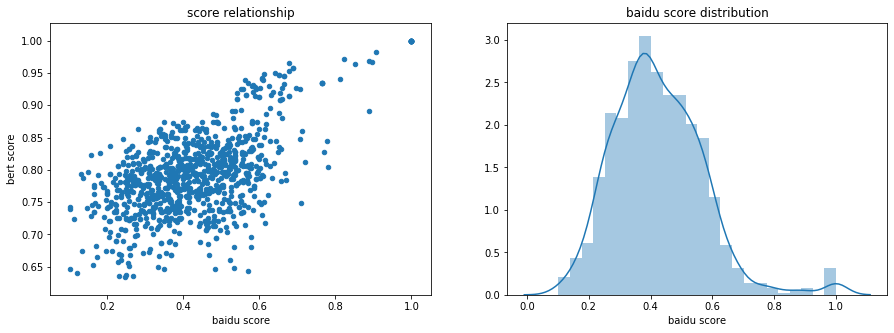

In [42]:
import statsmodels.api as sm
fig, ax= plt.subplots(1,2,figsize=(15,5))
compare.plot.scatter(x='baidu score',y='bert score',title='score relationship',ax=ax[0])
sns.distplot(compare['baidu score'],ax=ax[1])
ax[1].set_title('baidu score distribution')
mod=sm.OLS(compare['bert score'].values.tolist(),compare['baidu score'].values.tolist()).fit()
print(mod.summary())

In [21]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
embadding=scaler.fit_transform(embadding.T).T
combind_biz_item=pd.concat([recent_biz_item,pd.DataFrame(embadding,index=recent_biz_item.index)],axis=1)
combind_biz_item.iloc[:,5:]=combind_biz_item.iloc[:,5:].mul(combind_biz_item['weight'].values.tolist(),axis=0)
combind_biz_item.head()

ts_code            bz_item      bz_sales  index    weight  \
end_date                                                                  
2019-06-30  600000.SH  利息:发放贷款及垫款:个人贷款()  4.831000e+10      0  0.223738   
2019-06-30  601021.SH               航空客运  6.944721e+09   8349  0.992130   
2019-06-30  601021.SH               航空货运  5.508894e+07   8350  0.007870   
2019-06-30  603993.SH               铌磷相关  2.354593e+09  14480  0.238184   
2019-06-30  603993.SH               铜金相关  6.519597e+08  14481  0.065951   

                   0         1         2         3         4         5  \
end_date                                                                 
2019-06-30  0.209934  0.096198 -0.055423 -0.068105  0.146926 -0.203863   
2019-06-30 -0.216519  0.011581 -0.536111 -0.835454  1.103367 -0.954295   
2019-06-30  0.001680  0.002640 -0.002555 -0.004620  0.008816 -0.005288   
2019-06-30 -0.092967  0.082046 -0.295369 -0.162471  0.141611 -0.217828   
2019-06-30 -0.000771  0.022121 -0.038036 -0.059368  0.015540 -0.019557   

                   6         7         8         9        10        11  \
end_date                                                                 
2019-06-30 -0.047722 -0.155049  0.161314  0.001844  0.061770 -0.126298   
2019-06-30  0.608086 -0.146601  0.689980  0.344410 -0.097297  0.147775   
2019-06-30  0.003567 -0.000614  0.007841  0.005396 -0.000272 -0.000857   
2019-06-30 -0.006237 -0.019100  0.037199  0.091754 -0.164066  0.067052   
2019-06-30  0.001856 -0.010326 -0.013749  0.085618 -0.024552  0.042640   

                  12        13        14        15        16        17  \
end_date                                                                 
2019-06-30  0.076391  0.122496  0.537382  0.009391 -0.151638  0.204340   
2019-06-30  1.194147 -0.998505  2.245598 -0.039487  0.218128 -0.079106   
2019-06-30  0.014632 -0.004913  0.016818  0.004591  0.004023  0.003485   
2019-06-30  0.103324 -0.212784  0.181763 -0.260878  0.115154 -0.061760   
2019-06-30  0.070375 -0.014790  0.069384 -0.052750  0.006894 -0.037104   

                  18        19        20        21        22        23  \
end_date                                                                 
2019-06-30  0.086954  0.154994  0.097161  0.067726  0.089229  0.169326   
2019-06-30 -0.077141 -0.363117 -0.411002  0.174409  0.378341  0.284288   
2019-06-30 -0.003829 -0.002152 -0.003513  0.000756  0.003027 -0.001038   
2019-06-30 -0.061540  0.041581  0.066705  0.004125  0.151138  0.137115   
2019-06-30 -0.022797  0.027932  0.002894  0.007124  0.046285  0.016293   

                  24        25        26        27        28        29  \
end_date                                                                 
2019-06-30  0.158427 -0.051381  0.092679 -0.079459  0.064828 -0.046282   
2019-06-30 -0.472571  0.818440  0.471666 -0.858385 -0.016511  0.777434   
2019-06-30 -0.002436  0.009302  0.000999 -0.003342 -0.001219  0.006066   
2019-06-30  0.126650  0.142291  0.171868  0.042513  0.168658 -0.023225   
2019-06-30  0.012829  0.045037  0.006006 -0.027662  0.055557  0.042786   

                  30        31        32        33        34        35  \
end_date                                                                 
2019-06-30 -0.062284 -0.014128 -0.034667  0.073034  0.012330  0.076236   
2019-06-30 -0.707084  0.720679 -0.975431 -0.198932 -0.442974  1.907426   
2019-06-30 -0.008169  0.004069 -0.010509 -0.004064 -0.001116  0.014340   
2019-06-30 -0.064381 -0.115557  0.248291 -0.221800  0.130275  0.097000   
2019-06-30 -0.027067 -0.044417  0.030901 -0.012091 -0.009264 -0.001545   

                  36        37        38        39        40        41  \
end_date                                                                 
2019-06-30 -0.073374  0.189826  0.136548 -0.092363 -0.082804 -0.070765   
2019-06-30  0.118003  0.472646  1.412941 -0.408834  0.038278 -0.552525   
2019-06-30 -0.000526 -0.000390  0.009967 -0.006426  0.002323 -0.004236   
2019

In [80]:
company_map={}
for i in stock_index:
    company_map[i]={}
    i_company=combind_biz_item[combind_biz_item['ts_code']==i].iloc[:,5:].values
    n_i=i_company.shape[0]
    for j in stock_index:
        j_company=combind_biz_item[combind_biz_item['ts_code']==j].iloc[:,5:].values
        n_j=j_company.shape[0]
        temp_matrix=np.concatenate((i_company,j_company),axis=0)
        cor_matrix=np.cov(temp_matrix)[n_i:,:n_i]
        company_map[i][j]=cor_matrix.sum()

In [23]:
all_relation=[]
for key,items in company_map.items():
    for subkey,subitems in items.items():
        all_relation.append(subitems)

The maximum of bert corr is  1.0013037836935574
The minimum of bert corr is  0.5852923280921252


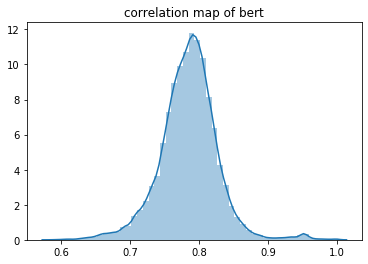

In [28]:
sns.distplot(all_relation)
plt.title('correlation distribution of bert')
print('The maximum of bert corr is ',max(all_relation))
print('The minimum of bert corr is ',min(all_relation))

In [79]:
company_map

{'601021.SH': {'601021.SH': 0.9918440228963805,
  '603993.SH': -0.7189690622774926,
  '000069.SZ': -0.324825796410789,
  '600015.SH': -0.6713884135584124,
  '601607.SH': -0.42102554013165217,
  '300124.SZ': -0.5903077087488469,
  '000876.SZ': -0.2561107129195482,
  '601088.SH': -0.3886204911470161,
  '000728.SZ': -0.4628717710554205,
  '000898.SZ': -0.6351255469405963,
  '000629.SZ': -0.4844387724027538,
  '600066.SH': -0.15062046754976524,
  '600297.SH': -0.29815402460960355,
  '600585.SH': -0.49457497130523875,
  '002304.SZ': -0.5049377597738565,
  '601838.SH': -0.6430863841664604,
  '600383.SH': -0.3844974649255753,
  '600516.SH': -0.4532409336921968,
  '603799.SH': -0.8080992196889649,
  '601236.SH': -0.5285969985774872,
  '601336.SH': -0.6027931046366826,
  '002736.SZ': -0.45539945820588634,
  '600362.SH': -0.6157212032807962,
  '000002.SZ': -0.3767724286586738,
  '601360.SH': -0.6595349668593561,
  '600031.SH': -0.17853002425191214,
  '000627.SZ': -0.7533179280392299,
  '000858.S

Text(0.5, 1.0, 'correlation distribution of baidu')

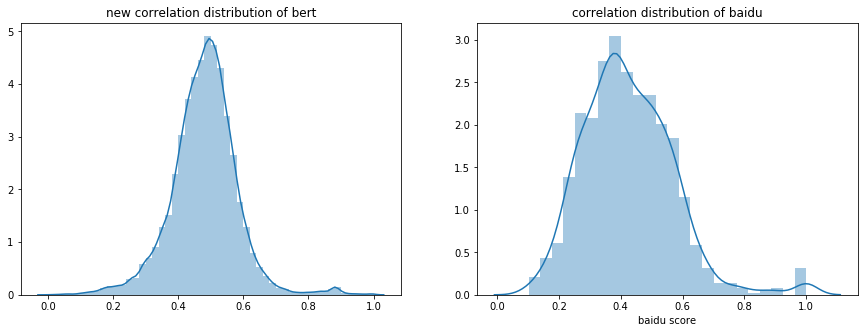

In [107]:
##change bert distribution to 0-1
transferd_company_map=copy.deepcopy(company_map)
all_transferd_relation=[]
base=min(all_relation)
scale=max(all_relation)-base
for key, item in transferd_company_map.items():
    for subkey,subitem in item.items():
        transferd_company_map[key][subkey]=(subitem-base)/scale
        all_transferd_relation.append((subitem-base)/scale)
fig, ax= plt.subplots(1,2,figsize=(15,5))
sns.distplot(all_transferd_relation,ax=ax[0])
ax[0].set_title('new correlation distribution of bert')

sns.distplot(compare['baidu score'],ax=ax[1])
ax[1].set_title('correlation distribution of baidu')